In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from sklearn.cluster import KMeans

def generar_muestra(a, sigma, cantidad_puntos):
    ''' Función para generar muestras en una reta con ruido
        param: a: Pendiente
               sigma: Varianza del ruido
               cantidad_puntos: Cantidad de puntos a simular

        output: Lista de x e y representando las coordenadas de los puntos sorteados
    '''
    x = np.random.rand(cantidad_puntos) * 20 - 10
    ruido = np.random.normal(loc=0, scale=sigma, size=cantidad_puntos)
    y = a*x + ruido

    return x, y

def rotacion(x, y, theta):
    ''' Función para rotar puntos en el plano un angulo theta
        param: x, y: coordeandas de los puntos (usualmente una lista para x y otra para y)
               theta: ángulo de rotación en radianes

        output:Lista de x2 e y2 representando las coordenadas de los puntos rotados
'''
    x2 = np.cos(theta) * x - np.sin(theta) * y
    y2 = np.sin(theta) * x + np.cos(theta) * y

    return x2, y2


def regresion_lineal(x, y):
    '''Función para calcular la regresión lineal
       param: x,y: coordeandas de los puntos (usualmente una lista para x y otra para y)

       output: Estimaciones de a y b, la pendiente y el intercept de la regresión
    '''
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_x2 = np.sum(x**2)
    sum_xy = np.sum(x*y)

    a_hat = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x ** 2)
    b_hat = (sum_y - a_hat * sum_x) / n

    return a_hat, b_hat

def regresion_rotada(a, b, theta):
    '''Función para 'rotar' los parámetros de una regresión
        param: a, b: Parámetros de la regresión original
              theta: ángulo de rotación en radianes

        output: Parámetros de la regresión rotada
    '''
    a_r = (a * np.cos(theta) + np.sin(theta)) / (np.cos(theta) - a * np.sin(theta))
    b_r = b * (a_r * np.sin(theta) + np.cos(theta))

    return a_r, b_r

def error_cuadratico_medio(y_real, y_pred):
    '''Función para calcular el ECM
       param: y_real: Lista de valores reales de y
              y_pred: Lista de valores predichos de y

        output: ECM
    '''
    return np.mean((y_real - y_pred) ** 2)

def estimacion_angulo(x1, y1, x2, y2):
    '''Función para estimar el ángulo de rotación usando arctan2
       suponiendo que (x2, y2) es el punto (x1, y1)
       rotado un ángulo theta
       param: x1, y1: coordenadas del punto original
              x2, y2: coordenadas del punto rotado
    '''
    # Calcular el ángulo usando arctan2
    theta = np.arctan2(y2, x2) - np.arctan2(y1, x1)

    theta = (theta + np.pi) % (2 * np.pi) - np.pi

    
    return theta





def estimacion_del_angulo_SVD(x1, y1, x2, y2, nt):
    """Función para estimar el ángulo de rotación utilizando transporte óptimo y SVD."""
    # Combinamos las coordenadas en un solo array para cada conjunto de muestras
    Xs = np.vstack((x1, y1)).T
    Xt = np.vstack((x2, y2)).T

    # K-means en Xs para obtener nt centroides
    kmeans = KMeans(n_clusters=nt, random_state=0, n_init=1).fit(Xs)
    centroides = kmeans.cluster_centers_

    # Densidades uniformes
    mu_centroides = np.ones(nt) / nt
    nu = np.ones(nt) / nt

    # Calcular la matriz de costo utilizando la distancia euclidiana
    C = ot.dist(centroides, Xt, metric='euclidean')

    # Resolución del problema de Monge
    P_gamma = ot.emd(mu_centroides, nu, C)

    # Mapear los centroides de Xs a los puntos en Xt usando la matriz de transporte
    indices_mapeados = np.argmax(P_gamma, axis=1)
    centroides_transportados = Xt[indices_mapeados]

    # Usar SVD para estimar la rotación
    H = np.dot(centroides.T, centroides_transportados)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # Asegurarse de que la matriz de rotación no refleje los puntos
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Estimar el ángulo de rotación
    theta = np.arctan2(R[1, 0], R[0, 0])

    return theta


def lala(x1, y1, x2, y2, n_rep=2000, p=0.8, verbose=False):
    A_r = []
    B_r = []

    A_2 = []
    B_2 = []

    Xs = np.vstack((x1, y1)).T
    ns = len(x1)
    nt = len(x2)
    
    for sorteo in range(n_rep):
        if verbose==True:
            if sorteo % 500 == 0:
                print(sorteo)

        indices_sorteados = np.random.choice(ns, int(np.floor(ns * p)), replace=False)
        Xs_sorteado = Xs[indices_sorteados]
        x1_s, y1_s = Xs_sorteado[:, 0], Xs_sorteado[:, 1]

        theta_estimado = estimacion_del_angulo_SVD(x1_s, y1_s, x2, y2, nt)

        # Regresiones
        a1_hat, b1_hat = regresion_lineal(x1, y1)
        a2_hat, b2_hat = regresion_lineal(x2, y2)
        a_r, b_r = regresion_rotada(a1_hat, b1_hat, theta_estimado)
        
        A_2.append(a2_hat)
        B_2.append(b2_hat)

        A_r.append(a_r)
        B_r.append(b_r)

    return A_2, B_2, A_r, B_r


Theta: 0.5235987755982988, Repetición: 0
Theta: 0.5235987755982988, Repetición: 10
Theta: 0.5235987755982988, Repetición: 20
Theta: 0.5235987755982988, Repetición: 30
Theta: 0.5235987755982988, Repetición: 40
Theta: 0.6283185307179586, Repetición: 0
Theta: 0.6283185307179586, Repetición: 10
Theta: 0.6283185307179586, Repetición: 20
Theta: 0.6283185307179586, Repetición: 30
Theta: 0.6283185307179586, Repetición: 40
Theta: 0.7853981633974483, Repetición: 0
Theta: 0.7853981633974483, Repetición: 10
Theta: 0.7853981633974483, Repetición: 20
Theta: 0.7853981633974483, Repetición: 30
Theta: 0.7853981633974483, Repetición: 40
Theta: 1.0471975511965976, Repetición: 0
Theta: 1.0471975511965976, Repetición: 10
Theta: 1.0471975511965976, Repetición: 20
Theta: 1.0471975511965976, Repetición: 30
Theta: 1.0471975511965976, Repetición: 40


Text(0.5, 0.98, 'MSE: regresión en $X_t$ vs regresión rotada')

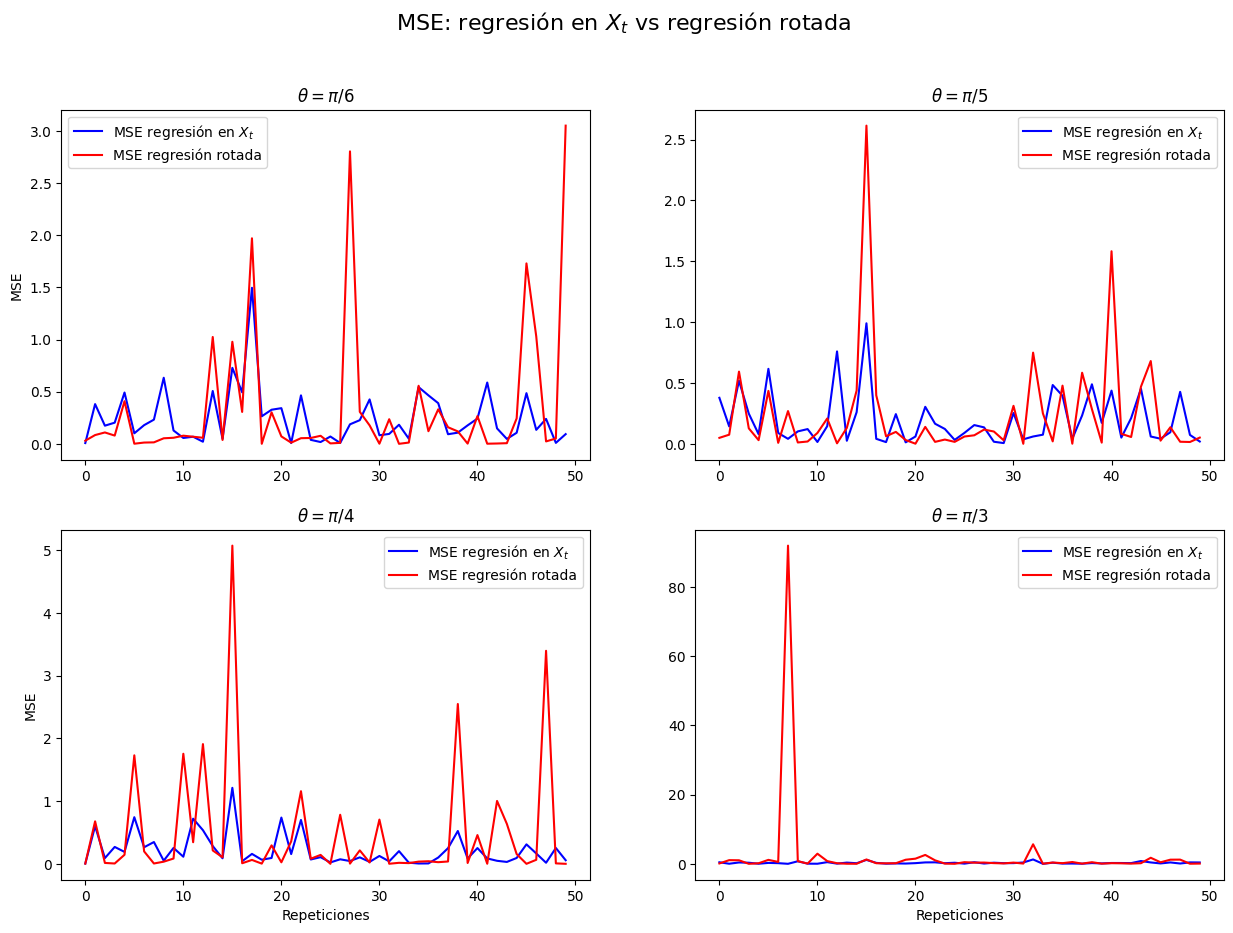

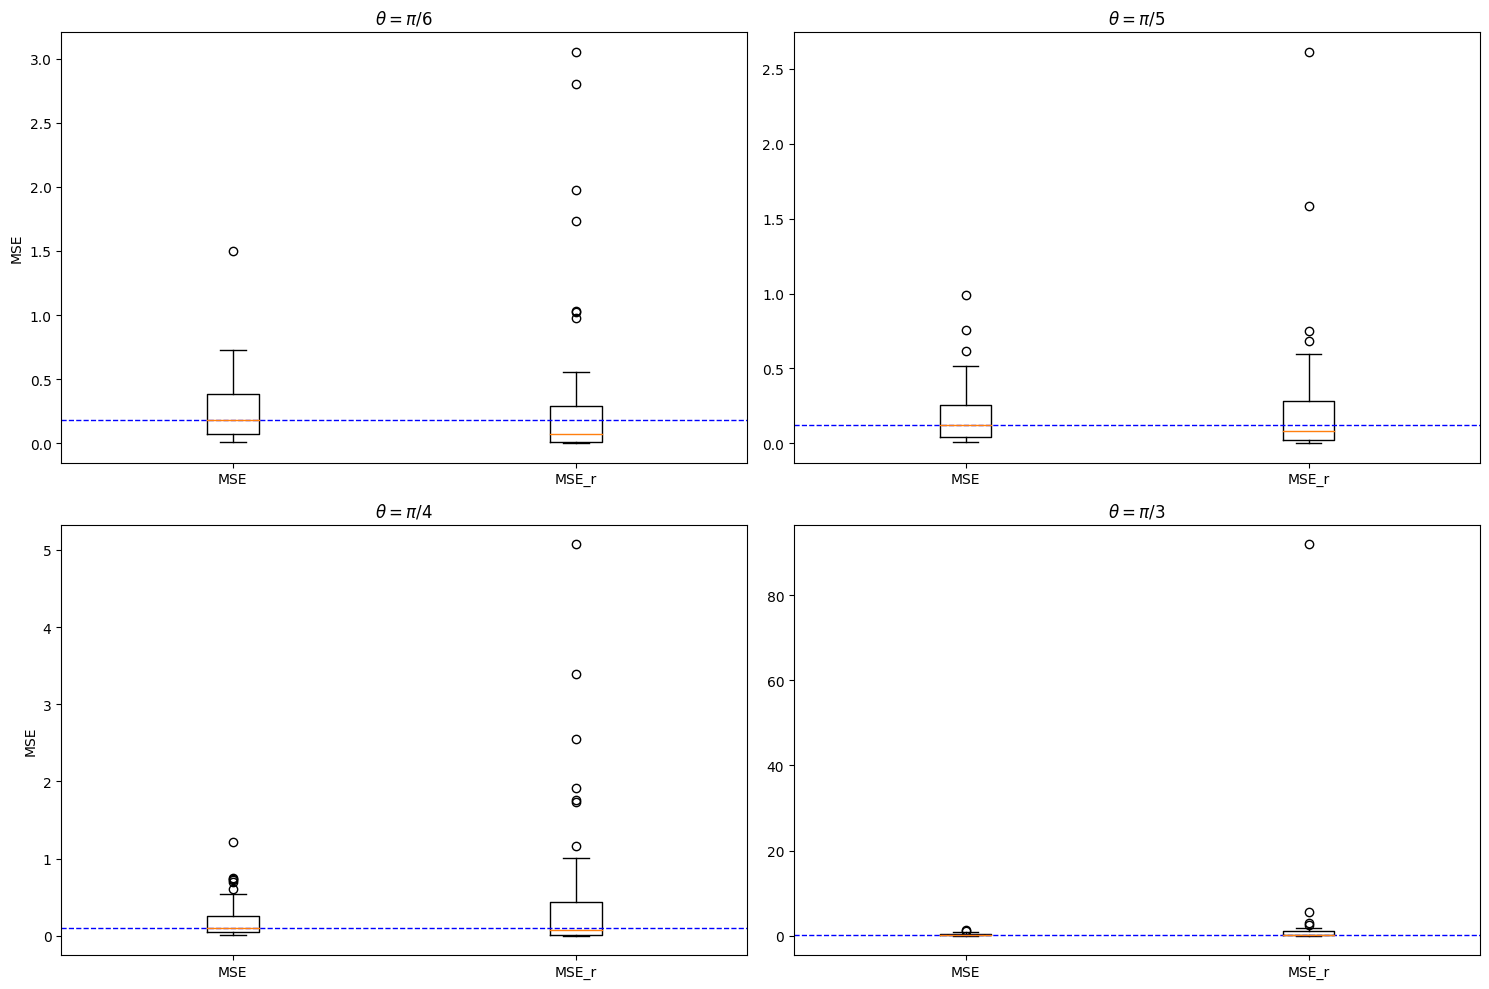

In [5]:
# Parámetros
thetas = [np.pi/6, np.pi/5, np.pi/4, np.pi/3]
thetas_plot = [r"$\theta=\pi/6$", r"$\theta=\pi/5$", r"$\theta=\pi/4$", r"$\theta=\pi/3$"]
a1, sigma1, ns = 0, 1, 1000
sigma2, nt = 1, 10

# Preparar los gráficos
fig_lines, axes_lines = plt.subplots(2, 2, figsize=(15, 10))
fig_boxplots, axes_boxplots = plt.subplots(2, 2, figsize=(15, 10))

for idx, theta_conocido in enumerate(thetas):
    MSE = []
    MSE_r = []
    a2 = np.tan(theta_conocido)

    for rep in range(50):
        if rep % 10 == 0:
            print(f"Theta: {theta_conocido}, Repetición: {rep}")

        # Generar muestras
        x1, y1 = generar_muestra(a1, sigma1, ns)
        x2, y2 = generar_muestra(a2, sigma2, nt)

        # Llamar a la función lala
        A_2, B_2, A_r, B_r = lala(x1, y1, x2, y2, n_rep=2000, p=0.8, verbose=False)

        a_2 = np.mean(A_2)
        b_2 = np.mean(B_2)
        a_r = np.mean(A_r)
        b_r = np.mean(B_r)

        x = np.linspace(-10, 10, 100)
        y_real = np.tan(theta_conocido) * x
        y_pred = a_2 * x + b_2
        y_pred_r = a_r * x + b_r

        mse_pred = round(error_cuadratico_medio(y_real, y_pred), 3)
        mse_r = round(error_cuadratico_medio(y_real, y_pred_r), 3)
        MSE.append(mse_pred)
        MSE_r.append(mse_r)

    # Graficar los resultados de MSE y MSE_r para este valor de theta (gráficos de líneas)
    ax_lines = axes_lines[idx // 2, idx % 2]
    ax_lines.plot(MSE, color="blue", label=r"MSE regresión en $X_t$")
    ax_lines.plot(MSE_r, color="red", label="MSE regresión rotada")
    ax_lines.set_title(thetas_plot[idx])
    if idx % 2 == 0:
        ax_lines.set_ylabel('MSE')
    if idx // 2 == 1:
        ax_lines.set_xlabel('Repeticiones')
    ax_lines.legend()

    # Graficar los boxplots de los resultados para este valor de theta (boxplots)
    ax_boxplots = axes_boxplots[idx // 2, idx % 2]
    ax_boxplots.boxplot([MSE, MSE_r], labels=['MSE', 'MSE_r'])
    ax_boxplots.set_title(thetas_plot[idx])
    if idx % 2 == 0:
        ax_boxplots.set_ylabel('MSE')

    # Agregar líneas horizontales a la altura de la mediana de MSE
    median_MSE = np.median(MSE)
    ax_boxplots.axhline(median_MSE, color='blue', linestyle='--', linewidth=1)

plt.tight_layout()

# Mostrar los gráficos por separado
fig_lines.suptitle(r'MSE: regresión en $X_t$ vs regresión rotada', fontsize=16)